In [ ]:
!pip install tensorflow_addons

In [ ]:
import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import numpy as np
import tensorflow_addons as tfa
import PIL
import shutil
import zipfile
import os
import io
import glob  # finding image paths
from skimage.io import imread  # reading images
from skimage.transform import resize  # resizing images

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

Number of replicas: 1
2.8.0


Imports

In [ ]:
# 2. Obtain paths of images (.png used for example)
face_img_list = sorted(glob.glob('Faces_Dataset/*.jpg'))

# 3. Read images & convert to numpy arrays
## create placeholding numpy arrays
IMG_SIZE = 256
x_data = np.empty((len(face_img_list), IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)

## read and convert to arrays
for i, img_path in enumerate(face_img_list):
    # read image
    img = imread(img_path)
    # resize image (1 channel used for example; 1 for gray-scale, 3 for RGB-scale)
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 3), preserve_range=True)
    # save to numpy array
    x_data[i] = img

In [ ]:
# 2. Obtain paths of images (.png used for example)
portrait_painting_list = sorted(glob.glob('Portrait_Dataset/*.png'))

# 3. Read images & convert to numpy arrays
## create placeholding numpy arrays
y_data = np.empty((len(portrait_painting_list), IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)

## read and convert to arrays
for j, img_path2 in enumerate(portrait_painting_list):
    # read image
    img1 = imread(img_path2)
    # resize image (1 channel used for example; 1 for gray-scale, 3 for RGB-scale)
    img1 = resize(img1, output_shape=(IMG_SIZE, IMG_SIZE, 3), preserve_range=True)
    # save to numpy array
    y_data[j] = img1

## **Test here**

In [ ]:
face_data = x_data.astype('float32')
face_data = (face_data - 127.5) / 127.5 # Normalize the image to [-1, 1]

portrait_data = y_data.astype('float32')
portrait_data = (portrait_data - 127.5) / 127.5 # Normalize the image to [-1, 1]

BUFFER_SIZE = 60000
FACE_BATCH_SIZE = 5
PORTRAIT_BATCH_SIZE = 5

# Batch and shuffle the data
face_dataset = tf.data.Dataset.from_tensor_slices(face_data).shuffle(BUFFER_SIZE).batch(FACE_BATCH_SIZE)
portrait_dataset = tf.data.Dataset.from_tensor_slices(portrait_data).shuffle(BUFFER_SIZE).batch(PORTRAIT_BATCH_SIZE)
print(type(face_dataset), face_dataset)
print(type(portrait_dataset), portrait_dataset)

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'> <BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'> <BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>


In [ ]:
fast_portrait_ds = tf.data.Dataset.from_tensor_slices(portrait_data).batch(30*strategy.num_replicas_in_sync).prefetch(30)
fid_portrait_ds = tf.data.Dataset.from_tensor_slices(portrait_data).take(1024).batch(30*strategy.num_replicas_in_sync).prefetch(30)
fid_face_ds = tf.data.Dataset.from_tensor_slices(face_data).batch(30*strategy.num_replicas_in_sync).prefetch(30)

In [ ]:
example_portrait = next(iter(portrait_dataset))
example_face = next(iter(face_dataset))

In [ ]:
plt.subplot(121)
plt.title('Face')
plt.imshow(example_face[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Portrait')
plt.imshow(example_portrait[0] * 0.5 + 0.5)

In [ ]:
OUTPUT_CHANNELS = 3

def down_sample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    layer = tf.keras.Sequential()
    layer.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        layer.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    layer.add(tf.keras.layers.LeakyReLU())

    return layer

In [ ]:
def up_sample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    layer = tf.keras.Sequential()
    layer.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer,use_bias=False))
    layer.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        layer.add(tf.keras.layers.Dropout(0.5))

    layer.add(tf.keras.layers.ReLU())

    return layer

In [ ]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        down_sample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        down_sample(128, 4), # (bs, 64, 64, 128)
        down_sample(256, 4), # (bs, 32, 32, 256)
        down_sample(512, 4), # (bs, 16, 16, 512)
        down_sample(512, 4), # (bs, 8, 8, 512)
        down_sample(512, 4), # (bs, 4, 4, 512)
        down_sample(512, 4), # (bs, 2, 2, 512)
        down_sample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        up_sample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        up_sample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        up_sample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        up_sample(512, 4), # (bs, 16, 16, 1024)
        up_sample(256, 4), # (bs, 32, 32, 512)
        up_sample(128, 4), # (bs, 64, 64, 256)
        up_sample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = down_sample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = down_sample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = down_sample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
def DHead():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[30, 30, 1], name='input_image')
    x = inp

    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x) # (size, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
def DiscriminatorP():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp

    down1 = down_sample(64, 4, False)(x)
    down2 = down_sample(128, 4)(down1)
    down3 = down_sample(256, 4)(down2)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
with strategy.scope():
    face_generator = Generator() # transforms portraits to face-like photos
    portrait_generator = Generator() # transforms face photos to be more like portraits

    face_discriminator = Discriminator() # differentiates real face photos and generated face photos
    portrait_discriminator = DiscriminatorP() # differentiates real portraits and generated portraits
    dHead1 = DHead() # Head for BCE
    dHead2 = DHead() # Head for hinge loss

In [ ]:
to_face = face_generator(example_portrait)

plt.subplot(1, 2, 1)
plt.title("Original poertrait")
plt.imshow(example_portrait[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Face-like Photo")
plt.imshow(to_face[0] * 0.5 + 0.5)
plt.show()

NameError: ignored

In [ ]:
class CycleGan(tf.keras.Model):
    def __init__(
        self,
        face_generator,
        portrait_generator,
        face_discriminator,
        portrait_discriminator,
        dhead1,
        dhead2,
        lambda_cycle=3,
        lambda_id=3,
    ):
        super(CycleGan, self).__init__()
        self.f_gen = face_generator
        self.p_gen = portrait_generator
        self.f_disc = face_discriminator
        self.p_disc = portrait_discriminator
        self.lambda_cycle = lambda_cycle
        self.lambda_id = lambda_id
        self.dhead1 = dhead1
        self.dhead2 = dhead2

    def compile(
        self,
        f_gen_optimizer,
        p_gen_optimizer,
        f_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn1,
        gen_loss_fn2,
        disc_loss_fn1,
        disc_loss_fn2,
        cycle_loss_fn,
        identity_loss_fn,
        aug_fn,

    ):
        super(CycleGan, self).compile()
        self.f_gen_optimizer = f_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.f_disc_optimizer = f_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn1 = gen_loss_fn1
        self.gen_loss_fn2 = gen_loss_fn2
        self.disc_loss_fn1 = disc_loss_fn1
        self.disc_loss_fn2 = disc_loss_fn2
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        self.aug_fn = aug_fn

        self.step_num = 0

    def train_step(self, batch_data):
        real_face, real_portrait = batch_data
        batch_size = tf.shape(real_face)[0]
        with tf.GradientTape(persistent=True) as tape:

            # portrait to face back to portrait
            fake_face = self.f_gen(real_portrait, training=True)
            cycled_portrait = self.p_gen(fake_face, training=True)

            # face to portrait back to face
            fake_portrait = self.p_gen(real_face, training=True)
            cycled_face = self.f_gen(fake_portrait, training=True)

            # generating itself
            same_face = self.f_gen(real_face, training=True)
            same_portrait = self.p_gen(real_portrait, training=True)



            # Diffaugment
            both_face = tf.concat([real_face, fake_face], axis=0)

            aug_face = self.aug_fn(both_face)

            aug_real_face = aug_face[:batch_size]
            aug_fake_face = aug_face[batch_size:]


            # two-objective discriminator
            disc_fake_face1 = self.dhead1(self.f_disc(aug_fake_face, training=True), training=True)
            disc_real_face1 = self.dhead1(self.f_disc(aug_real_face, training=True), training=True)
            disc_fake_face2 = self.dhead2(self.f_disc(aug_fake_face, training=True), training=True)
            disc_real_face2 = self.dhead2(self.f_disc(aug_real_face, training=True), training=True)

            face_gen_loss1 = self.gen_loss_fn1(disc_fake_face1)
            face_head_loss1 = self.disc_loss_fn1(disc_real_face1, disc_fake_face1)
            face_gen_loss2 = self.gen_loss_fn2(disc_fake_face2)
            face_head_loss2 = self.disc_loss_fn2(disc_real_face2, disc_fake_face2)



            face_gen_loss = (face_gen_loss1 + face_gen_loss2) * 0.4
            face_disc_loss = face_head_loss1 + face_head_loss2




            # discriminator used to check, inputing real images

            disc_real_portrait = self.p_disc(real_portrait, training=True)
            # discriminator used to check, inputing fake images

            disc_fake_portrait = self.p_disc(fake_portrait, training=True)

            # evaluates generator loss

            portrait_gen_loss = self.gen_loss_fn1(disc_fake_portrait)

            # evaluates discriminator loss

            portrait_disc_loss = self.disc_loss_fn1(disc_real_portrait, disc_fake_portrait)


            # evaluates total generator loss
            total_cycle_loss = self.cycle_loss_fn(real_face, cycled_face, self.lambda_cycle/ tf.cast(batch_size,tf.float32)) + self.cycle_loss_fn(real_portrait, cycled_portrait, self.lambda_cycle/ tf.cast(batch_size,tf.float32))

            # evaluates total generator loss
            total_face_gen_loss = face_gen_loss + total_cycle_loss +  self.identity_loss_fn(real_face, same_face, self.lambda_id / tf.cast(batch_size,tf.float32))
            total_portrait_gen_loss = portrait_gen_loss + total_cycle_loss + self.identity_loss_fn(real_portrait, same_portrait, self.lambda_id/ tf.cast(batch_size,tf.float32))



        # Calculate the gradients for generator and discriminator
        face_generator_gradients = tape.gradient(total_face_gen_loss,
                                                  self.f_gen.trainable_variables)
        portrait_generator_gradients = tape.gradient(total_portrait_gen_loss,
                                                  self.p_gen.trainable_variables)

        face_discriminator_gradients = tape.gradient(face_disc_loss,
                                                      self.f_disc.trainable_variables)
        portrait_discriminator_gradients = tape.gradient(portrait_disc_loss,
                                                      self.p_disc.trainable_variables)


        # Heads gradients
        face_head_gradients = tape.gradient(face_head_loss1,
                                                      self.dhead1.trainable_variables)

        self.f_disc_optimizer.apply_gradients(zip(face_head_gradients,
                                                  self.dhead1.trainable_variables))

        face_head_gradients = tape.gradient(face_head_loss2,
                                                      self.dhead2.trainable_variables)
        self.f_disc_optimizer.apply_gradients(zip(face_head_gradients,
                                                  self.dhead2.trainable_variables))



        # Apply the gradients to the optimizer
        self.f_gen_optimizer.apply_gradients(zip(face_generator_gradients,
                                                 self.f_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(portrait_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.f_disc_optimizer.apply_gradients(zip(face_discriminator_gradients,
                                                  self.f_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(portrait_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "face_head_loss1": face_head_loss1,
            "face_head_loss2": face_head_loss2,
            "disc_real_face": disc_real_face1,
            "disc_fake_face": disc_fake_face1,
            "disc_real_face2": disc_real_face2,
            "disc_fake_face2": disc_fake_face2,
            "face_gen_loss": face_gen_loss,
            "portrait_disc_loss": portrait_disc_loss,
            }

In [ ]:
with strategy.scope(): # for TPU

    def discriminator_loss1(real, generated):
        real_loss = tf.math.minimum(tf.zeros_like(real), real-tf.ones_like(real))

        generated_loss = tf.math.minimum(tf.zeros_like(generated), -generated-tf.ones_like(generated))

        total_disc_loss = real_loss + generated_loss

        return tf.reduce_mean(-total_disc_loss * 0.5)

    def discriminator_loss2(real, generated):
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(real), real)
        total_disc_loss = real_loss + generated_loss

        return tf.reduce_mean(total_disc_loss * 0.5)

In [ ]:
with strategy.scope():
    def generator_loss1(generated):
        return  tf.reduce_mean(-generated)

    def generator_loss2(generated):
        return tf.reduce_mean(tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated))

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_sum(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1 * 0.0000152587890625

In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_sum(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss * 0.0000152587890625

In [ ]:
with strategy.scope():
    def DiffAugment(x, policy='', channels_first=False):
        if policy:
            if channels_first:
                x = tf.transpose(x, [0, 2, 3, 1])
            for p in policy.split(','):
                for f in AUGMENT_FNS[p]:
                    x = f(x)
            if channels_first:
                x = tf.transpose(x, [0, 3, 1, 2])
        return x


    def rand_brightness(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) - 0.5
        x = x + magnitude
        return x


    def rand_saturation(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2
        x_mean = tf.reduce_sum(x, axis=3, keepdims=True) * 0.3333333333333333333
        x = (x - x_mean) * magnitude + x_mean
        return x


    def rand_contrast(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
        x_mean = tf.reduce_sum(x, axis=[1, 2, 3], keepdims=True) * 5.086e-6
        x = (x - x_mean) * magnitude + x_mean
        return x

    def rand_translation(x, ratio=0.125):
        batch_size = tf.shape(x)[0]
        image_size = tf.shape(x)[1:3]
        shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
        translation_x = tf.random.uniform([batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
        translation_y = tf.random.uniform([batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)
        grid_x = tf.clip_by_value(tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0, image_size[0] + 1)
        grid_y = tf.clip_by_value(tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0, image_size[1] + 1)
        x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_x, -1), batch_dims=1)
        x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])
        return x


    def rand_cutout(x, ratio=0.5):
        batch_size = tf.shape(x)[0]
        image_size = tf.shape(x)[1:3]
        cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
        offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2), dtype=tf.int32)
        offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2), dtype=tf.int32)
        grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(cutout_size[0], dtype=tf.int32), tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')
        cutout_grid = tf.stack([grid_batch, grid_x + offset_x - cutout_size[0] // 2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)
        mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
        cutout_grid = tf.maximum(cutout_grid, 0)
        cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
        mask = tf.maximum(1 - tf.scatter_nd(cutout_grid, tf.ones([batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32), mask_shape), 0)
        x = x * tf.expand_dims(mask, axis=3)
        return x


    AUGMENT_FNS = {
        'color': [rand_brightness, rand_saturation, rand_contrast],
        'translation': [rand_translation],
        'cutout': [rand_cutout],
}
    def aug_fn(image):
        return DiffAugment(image,"color,translation,cutout")

In [ ]:
with strategy.scope():
    face_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    portrait_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    face_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    portrait_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        face_generator, portrait_generator, face_discriminator, portrait_discriminator, dHead1,  dHead2
    )

In [ ]:
with strategy.scope():

    cycle_gan_model.compile(
        f_gen_optimizer = face_generator_optimizer,
        p_gen_optimizer = portrait_generator_optimizer,
        f_disc_optimizer = face_discriminator_optimizer,
        p_disc_optimizer = portrait_discriminator_optimizer,
        gen_loss_fn1 = generator_loss1,
        gen_loss_fn2 = generator_loss2,
        disc_loss_fn1 = discriminator_loss1,
        disc_loss_fn2 = discriminator_loss2,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss,
        aug_fn = aug_fn ,


    )

In [ ]:
def get_gan_dataset(face_data, portrait_data, augment=None, repeat=True, shuffle=True, batch_size=1):

    face_ds = tf.data.Dataset.from_tensor_slices(face_data)
    portrait_ds = tf.data.Dataset.from_tensor_slices(portrait_data)

    face_ds = face_ds.batch(batch_size, drop_remainder=True)
    portrait_ds = portrait_ds.batch(batch_size, drop_remainder=True)
#     face_ds = face_ds.cache()
#     portrait_ds = portrait_ds.cache()
    face_ds = face_ds.prefetch(AUTOTUNE)
    portrait_ds = portrait_ds.prefetch(AUTOTUNE)

    gan_ds = tf.data.Dataset.zip((face_ds, portrait_ds))

    return gan_ds

In [ ]:
final_dataset = get_gan_dataset(face_data, portrait_data, augment=None, repeat=True, shuffle=True, batch_size=1)

In [ ]:
cycle_gan_model.fit(final_dataset,steps_per_epoch=100, epochs=10)

In [ ]:
with strategy.scope():

    inception_model = tf.keras.applications.InceptionV3(input_shape=(256,256,3),pooling="avg",include_top=False)

    mix3  = inception_model.get_layer("mixed9").output
    f0 = tf.keras.layers.GlobalAveragePooling2D()(mix3)

    inception_model = tf.keras.Model(inputs=inception_model.input, outputs=f0)
    inception_model.trainable = False



    def calculate_activation_statistics_mod(images,fid_model):

            act=tf.cast(fid_model.predict(images), tf.float32)

            mu = tf.reduce_mean(act, axis=0)
            mean_x = tf.reduce_mean(act, axis=0, keepdims=True)
            mx = tf.matmul(tf.transpose(mean_x), mean_x)
            vx = tf.matmul(tf.transpose(act), act)/tf.cast(tf.shape(act)[0], tf.float32)
            sigma = vx - mx
            return mu, sigma
    myFID_mu2, myFID_sigma2 = calculate_activation_statistics_mod(fid_face_ds,inception_model)
    fids=[]

In [ ]:
with strategy.scope():
    def calculate_frechet_distance(mu1,sigma1,mu2,sigma2):
        fid_epsilon = 1e-14

        covmean = tf.linalg.sqrtm(tf.cast(tf.matmul(sigma1,sigma2),tf.complex64))
#         isgood=tf.cast(tf.math.is_finite(covmean), tf.int32)
#         if tf.size(isgood)!=tf.math.reduce_sum(isgood):
#             return 0

        covmean = tf.cast(tf.math.real(covmean),tf.float32)

        tr_covmean = tf.linalg.trace(covmean)


        return tf.matmul(tf.expand_dims(mu1 - mu2, axis=0),tf.expand_dims(mu1 - mu2, axis=1)) + tf.linalg.trace(sigma1) + tf.linalg.trace(sigma2) - 2 * tr_covmean




    def FID(images,gen_model,inception_model=inception_model,myFID_mu2=myFID_mu2, myFID_sigma2=myFID_sigma2):
                inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
                x  = gen_model(inp)
                x=inception_model(x)
                fid_model = tf.keras.Model(inputs=inp, outputs=x)

                mu1, sigma1= calculate_activation_statistics_mod(images,fid_model)

                fid_value = calculate_frechet_distance(mu1, sigma1,myFID_mu2, myFID_sigma2)


                return fid_value

In [ ]:
FID(fid_portrait_ds,face_generator)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[35.40896]], dtype=float32)>

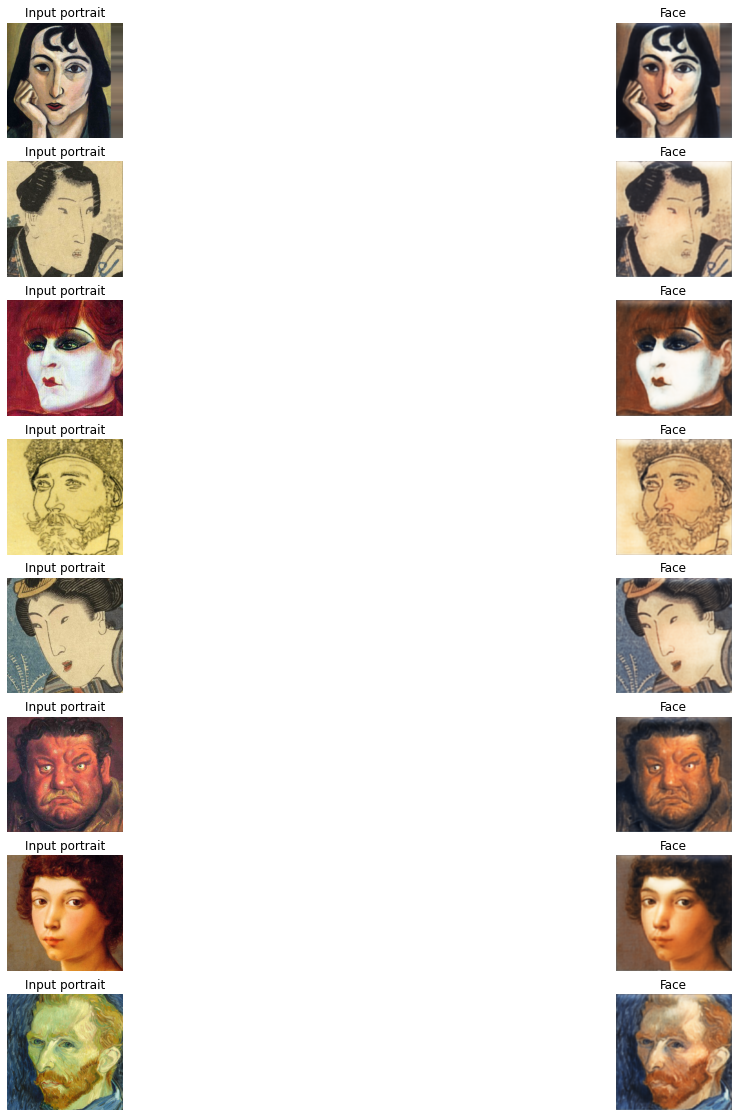

In [ ]:
_, ax = plt.subplots(8, 2, figsize=(20, 20))
for i, img in enumerate(portrait_dataset.take(8)):
    prediction = face_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input portrait")
    ax[i, 1].set_title("Face")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()